# DATA ANALYSIS WITH PYSPARK

**This notebook has the purpose of practice and understand the usage of pyspark to perform data analysis**

## IMPORTS

In [28]:
import os, sys, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

## HELPER FUNCTIONS

In [43]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
 
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 50
  
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sns.set()

def annot_plot(plot):
    for p in plot.patches:
        plot.annotate(format(round(float(p.get_height()),2)), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points',
                       fontsize = 14)
    return None

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## SET SPARK SESSION

**SparkSession**

    - A SparkSession is an entry point to underlying PySpark functionality in order to programmatically create PySpark RDD, DataFrame.

In [6]:
pyspark = SparkSession.builder.appName("temp_analysis").master('local[*]').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/30 08:24:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## LOAD DATAFRAME FROM PARQUET FILE

**RDD**

    - RDD stands for Resilient Distributed Dataset, these are the elements that run and operate on multiple nodes to do parallel processing on a cluster. RDDs are immutable elements.

In [7]:
df = pyspark.read.parquet('../../data/data_lake/cleansed/openweather_20211230.parquet')

## FIRST LOOK INTO THE DATA

In [9]:
df.show()

+-----+--------------------+-------------------+-----+---+----+-------+---------+-----------+-------+-------+--------+----------+------+----------+------------+----------+------+----------+------------+
|index|                  id|         created_at|month|day|hour|city_id|     city|    country|    lat|    lon|humidity|min_temp_F|temp_F|max_temp_F|feels_like_F|min_temp_C|temp_C|max_temp_C|feels_like_C|
+-----+--------------------+-------------------+-----+---+----+-------+---------+-----------+-------+-------+--------+----------+------+----------+------------+----------+------+----------+------------+
|    0|"61bf0e36c0963c89...|2021-12-19 11:49:26|   12| 19|  11|2950159|   Berlin|    Germany|52.5244|13.4105|      91|      42.1| 43.23|     45.75|       35.71|      5.61|  6.24|      7.64|        2.06|
|    1|"61bf0e3bc0963c89...|2021-12-19 11:49:31|   12| 19|  11|2988507|    Paris|     France|48.8534| 2.3488|      97|     39.27| 40.53|     41.85|       37.92|      4.04|  4.74|      5.47

In [14]:
# SHAPE
print(f"Number of rows: {df.count()}\nNumber of columns: {len(df.columns)}")

Number of rows: 1032
Number of columns: 20


In [17]:
# DESCRIBE GENERAL DF
df.describe(["humidity", "min_temp_F", "temp_F", "max_temp_F", "feels_like_F", "min_temp_C", "temp_C", "max_temp_C", "feels_like_C"]).show()

+-------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|         humidity|       min_temp_F|           temp_F|       max_temp_F|      feels_like_F|        min_temp_C|            temp_C|        max_temp_C|      feels_like_C|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|             1032|             1032|             1032|             1032|              1032|              1032|              1032|              1032|              1032|
|   mean|83.57751937984496|34.99080426356587|38.32457364341084|41.21692829457373|  35.4041182170543|1.6615116279069775|3.5135368217054297|5.1203682170542635|1.8911531007751947|
| stddev|9.222005818623831|8.842045970650746|9.013917701541759|9.169995666649813|10.435856629256618| 4.912428095974

In [21]:
# AVERAGE TEMPS GROUPED BY CITY
df.groupBy("city").mean("humidity", "min_temp_F", "temp_F", "max_temp_F", "feels_like_F", "min_temp_C", "temp_C", "max_temp_C", "feels_like_C").show()

+---------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|     city|    avg(humidity)|   avg(min_temp_F)|       avg(temp_F)|   avg(max_temp_F)| avg(feels_like_F)|    avg(min_temp_C)|       avg(temp_C)|   avg(max_temp_C)|  avg(feels_like_C)|
+---------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+
|   Berlin|88.53333333333333|30.073133333333367| 33.58613333333332| 36.47293333333328|27.781266666666653|-1.0706666666666662|0.8811333333333334| 2.484266666666666|-2.3436000000000003|
|   London|87.13793103448276|39.331310344827564|42.104827586206895| 44.44737931034484|  39.3364827586207|  4.072689655172413| 5.613586206896554|  6.91489655172414|  4.075862068965518|
|   Vienna|75.58219178082192|   30.928698630137| 35.03863013698631| 38.652945205

## DATA ANALYSIS WITH PYSPARK

#### DAILY TEMPERATURE ANALYSIS.

In [26]:
# AVERAGE TEMPS GROUPED BY CITY AND DAY
df_grouped_city_day = df.groupBy("city", "day").mean("humidity", "min_temp_F", "temp_F", "max_temp_F", "feels_like_F", "min_temp_C", "temp_C", "max_temp_C", "feels_like_C").orderBy("city", "day")
df_grouped_city_day.show()

+---------+---+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+
|     city|day|    avg(humidity)|   avg(min_temp_F)|       avg(temp_F)|   avg(max_temp_F)| avg(feels_like_F)|    avg(min_temp_C)|         avg(temp_C)|   avg(max_temp_C)|   avg(feels_like_C)|
+---------+---+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+
|Amsterdam| 19|             94.0|             42.87|             44.69|             46.85|             41.34|               6.04|                7.05|              8.25|                5.19|
|Amsterdam| 20|79.14814814814815| 37.22037037037038|40.352962962962955|  43.5451851851852| 39.76222222222221|   2.90037037037037|                4.64| 6.413703703703704|   4.311481481481481|
|Amsterdam| 21|88.94594594594595|29.190270270

In [27]:
# CREATE A TEMPVIEW
df_grouped_city_day.createOrReplaceTempView("mean_temp_by_city_and_day")

In [35]:
# USING SQL TO ANALYSE THE DATA

df1 = pyspark.sql("SELECT * FROM mean_temp_by_city_and_day")
df1.show()

+---------+---+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+
|     city|day|    avg(humidity)|   avg(min_temp_F)|       avg(temp_F)|   avg(max_temp_F)| avg(feels_like_F)|    avg(min_temp_C)|         avg(temp_C)|   avg(max_temp_C)|   avg(feels_like_C)|
+---------+---+-----------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+
|Amsterdam| 19|             94.0|             42.87|             44.69|             46.85|             41.34|               6.04|                7.05|              8.25|                5.19|
|Amsterdam| 20|79.14814814814815| 37.22037037037038|40.352962962962955|  43.5451851851852| 39.76222222222221|   2.90037037037037|                4.64| 6.413703703703704|   4.311481481481481|
|Amsterdam| 21|88.94594594594595|29.190270270

In [36]:
# DF1 TO PANDAS - PLOT
df1 = df1.toPandas()
df1.head()

,city,day,avg(humidity),avg(min_temp_F),avg(temp_F),avg(max_temp_F),avg(feels_like_F),avg(min_temp_C),avg(temp_C),avg(max_temp_C),avg(feels_like_C)
0,Amsterdam,19,94.000000,42.870000,44.690000,46.850000,41.340000,6.040000,7.050000,8.250000,5.190000
1,Amsterdam,20,79.148148,37.220370,40.352963,43.545185,39.762222,2.900370,4.640000,6.413704,4.311481
2,Amsterdam,21,88.945946,29.190270,32.127297,35.352973,31.354865,-1.560811,0.070541,1.862973,-0.358919
3,Amsterdam,22,89.906250,27.759063,30.153750,32.966562,27.040625,-2.356562,-1.025937,0.536875,-2.755000
4,Amsterdam,23,92.055556,35.763333,38.682222,41.877222,34.226667,2.091111,3.712222,5.487222,1.237222


/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


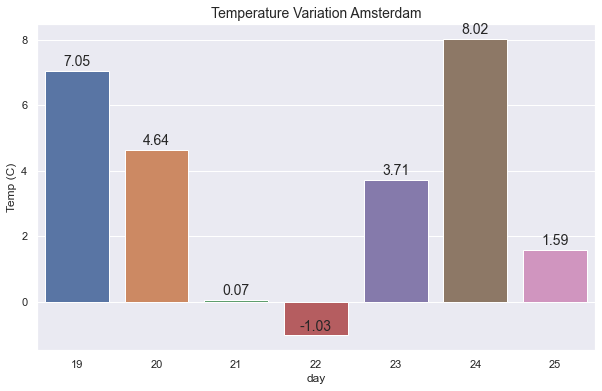

In [80]:
# TEMPERATURE VARIATION BY CITY
amsterdam = df1[df1['city'] == 'Amsterdam']

ax1 = sns.barplot(amsterdam['day'], amsterdam['avg(temp_C)'])
ax1.set_title("Temperature Variation Amsterdam", fontsize=14)
ax1.set_ylabel("Temp (C)")
annot_plot(ax1)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


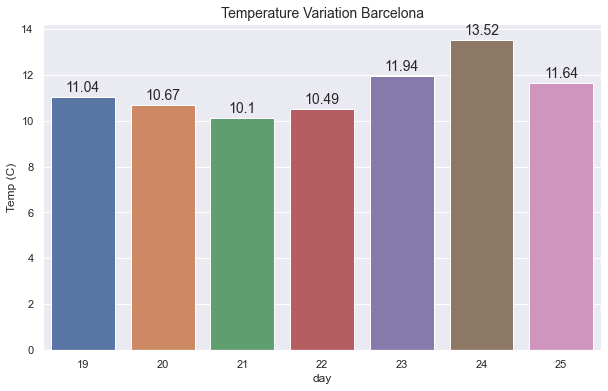

In [79]:
barcelona = df1[df1['city'] == 'Barcelona']
ax2 = sns.barplot(barcelona['day'], barcelona['avg(temp_C)'])
ax2.set_title("Temperature Variation Barcelona", fontsize=14)
ax2.set_ylabel("Temp (C)")
annot_plot(ax2)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


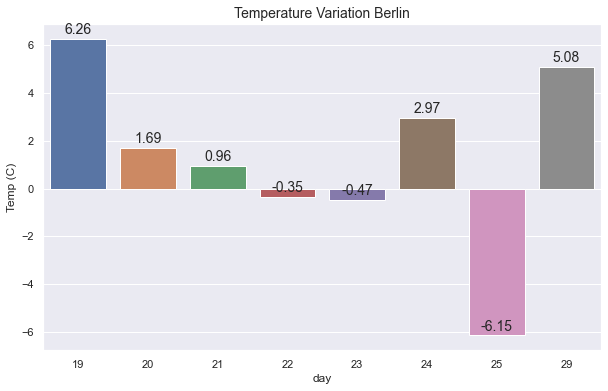

In [81]:
berlin = df1[df1['city'] == 'Berlin']

ax3 = sns.barplot(berlin['day'], berlin['avg(temp_C)'])
ax3.set_title("Temperature Variation Berlin", fontsize=14)
ax3.set_ylabel("Temp (C)")
annot_plot(ax3)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


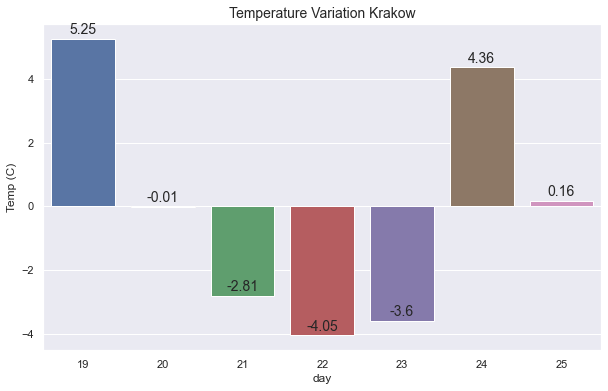

In [86]:
krakow = df1[df1['city'] == 'Krakow']

ax4 = sns.barplot(krakow['day'], krakow['avg(temp_C)'])
ax4.set_title("Temperature Variation Krakow", fontsize=14)
ax4.set_ylabel("Temp (C)")
annot_plot(ax4)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


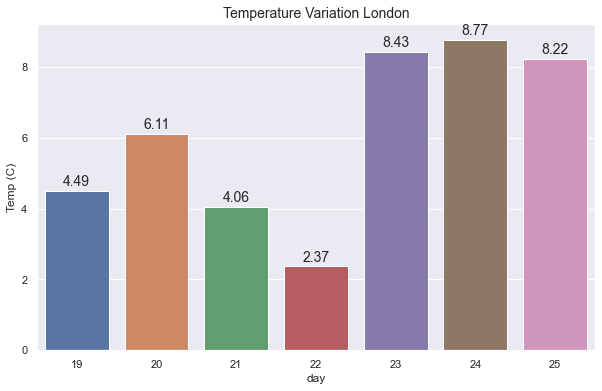

In [83]:
london = df1[df1['city'] == 'London']

ax5 = sns.barplot(london['day'], london['avg(temp_C)'])
ax5.set_title("Temperature Variation London", fontsize=14)
ax5.set_ylabel("Temp (C)")
annot_plot(ax5)

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


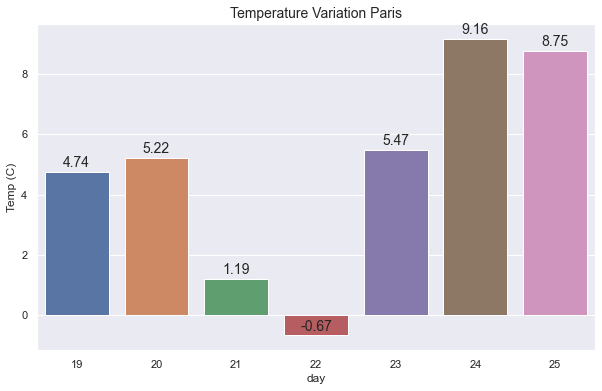

In [84]:
paris = df1[df1['city'] == 'Paris']

ax6 = sns.barplot(paris['day'], paris['avg(temp_C)'])
ax6.set_title("Temperature Variation Paris", fontsize=14)
ax6.set_ylabel("Temp (C)")
annot_plot(ax6)


/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


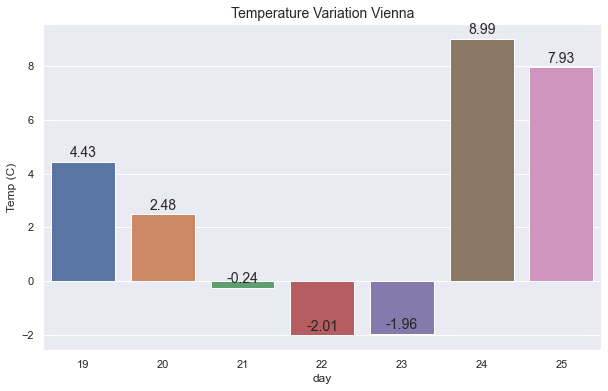

In [85]:
vienna = df1[df1['city'] == 'Vienna']

ax7 = sns.barplot(vienna['day'], vienna['avg(temp_C)'])
ax7.set_title("Temperature Variation Vienna", fontsize=14)
ax7.set_ylabel("Temp (C)")
annot_plot(ax7)